## Part 1: Play with the functions

### Compute Camera Calibration with OpenCV

In [89]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane

images = glob.glob('./camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)  # TODO (5,9) is ok?
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
    

img_temp = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img_temp.shape[1], img_temp.shape[0])

# Do camera calibration 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

print(mtx, '\n', dist)

[[  1.15777829e+03   0.00000000e+00   6.67113866e+02]
 [  0.00000000e+00   1.15282230e+03   3.86124658e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]] 
 [[-0.24688572 -0.02372825 -0.00109832  0.00035104 -0.00260431]]


### Undistort 

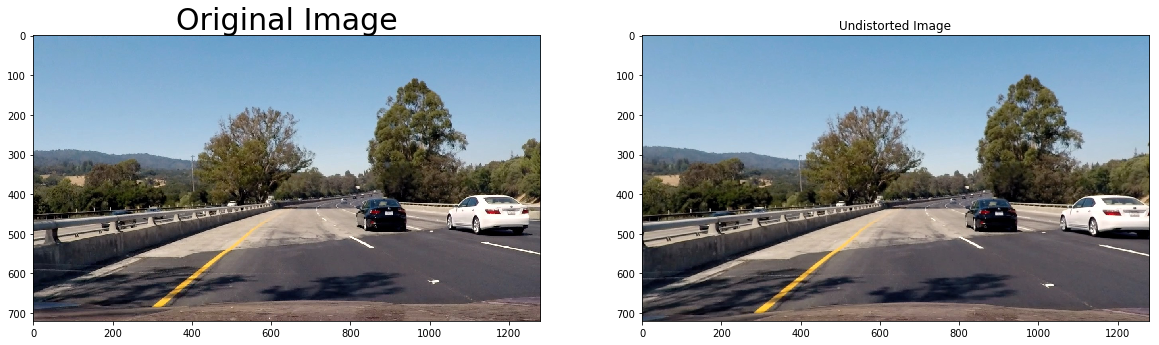

In [90]:
import pickle

# save & visualize
#img2 = cv2.imread('./camera_cal/calibration3.jpg')
img2 = mpimg.imread('./test_images/test4.jpg')
dst = cv2.undistort(img2, mtx, dist, None, mtx)
cv2.imwrite('output_images/test.jpg', dst)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("wide_dist_pickle.p", "wb"))

f,(ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image')


## perspective Transform

True 54


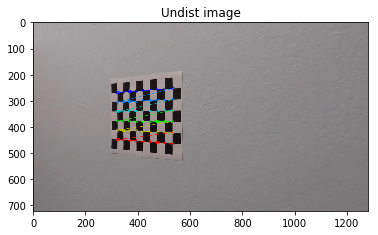

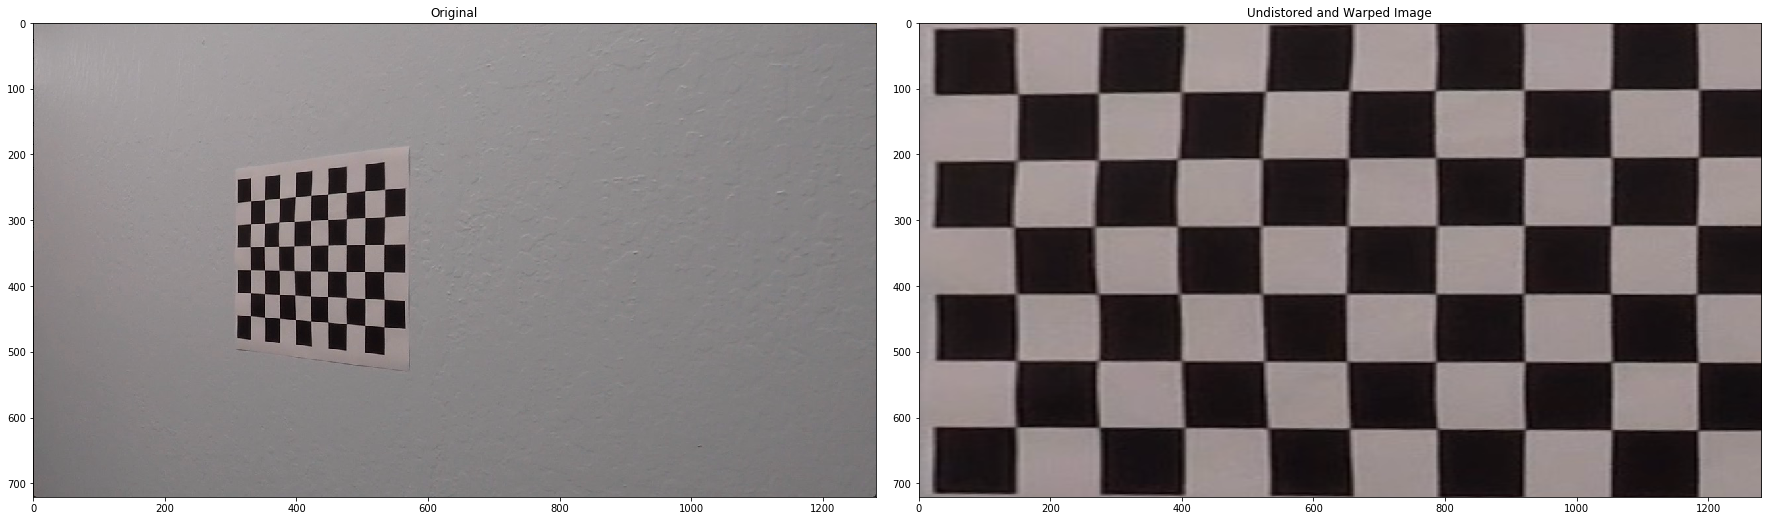

In [91]:
def corners_unwarp_test(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print(ret, len(corners))
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset],
                         [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset],
                         [offset, img_size[1]-offset]])
      
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
        return warped, M, undist
        

# Read in an image
img3 = cv2.imread('./camera_cal/calibration7.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M, undist = corners_unwarp_test(img3, nx, ny, mtx, dist)

plt.title('Undist image')
plt.imshow(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img3)
ax1.set_title('Original')
ax2.imshow(top_down)
ax2.set_title('Undistored and Warped Image')
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)



# src = [[118.5777359,156.49272156],
#        [1239.32458496,165.10397339],
#        [1073.08508301, 627.71679688],
#        [248.22479248,   640.61047363]] 
# dst = [[100.,100.],
#       [1180.,100.],
#       [1180.,620.],
#       [100.,620.]]

#plt.imshow(img3)
# plt.plot(src[0][0], src[0][1], '.') 
# plt.plot(src[1][0], src[1][1], '.')
# plt.plot(src[2][0], src[2][1], '.') 
# plt.plot(src[3][0], src[3][1], '.') 

# plt.imshow(img3)
# plt.plot(dst[0][0], dst[0][1], '.') 
# plt.plot(dst[1][0], dst[1][1], '.')
# plt.plot(dst[2][0], dst[2][1], '.') 
# plt.plot(dst[3][0], dst[3][1], '.') 

## sobel

In [231]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if len(img.shape) != 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
#     ret_test = apply_equalizeHist(img)    
#     gray = ret_test
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint(255*abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    gradmag = (gradmag * 255 / np.max(gradmag)).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)    
    direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

## HLS select

In [232]:

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
  
    sobel = cv2.Sobel(s, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint(255*abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s < thresh[1]) & ((scaled_sobel >= thresh[0]) | (scaled_sobel <= thresh[1]))] = 1
    return binary_output


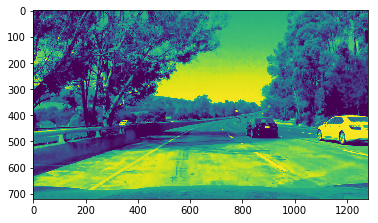

In [233]:
def apply_equalizeHist(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = img[:,:,2]
    equ = cv2.equalizeHist(img[:,:,1])
    #res = np.hstack((gray,equ)) #stacking images side-by-side
    return equ

img = cv2.imread('./test_images/test5.jpg')
ret_test = apply_equalizeHist(img)
plt.imshow(ret_test)

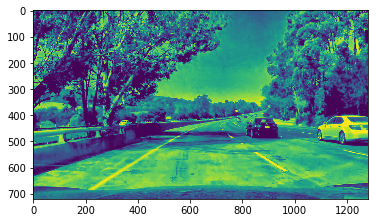

In [234]:
def apply_CLAHE(img):
    img = img[:,:,2]
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    
    return cl1

img_test = cv2.imread('./test_images/test5.jpg')
ret = apply_CLAHE(img_test)
plt.imshow(ret)

### pipeline: Deal the image.

In [241]:
s_thresh=(100, 255)
sobel_x_thresh=(80, 255)
mag_thresh=(80,255)
dir_thresh=(0,1.20)

def pipeline(img, s_thresh=(150, 255), sobel_x_thresh=(20, 40), mag_thresh=(0,255),dir_thresh=(0,255)):
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    # Threshold x gradient
    sobel_x_thresh_min = sobel_x_thresh[0]
    sobel_x_thresh_max = sobel_x_thresh[1]
    # mag thresh
    mag_thresh_min = mag_thresh[0]
    mag_thresh_max = mag_thresh[1]
    # dir thresh
    dir_thresh_min = dir_thresh[0]
    dir_thresh_max = dir_thresh[1]
    
    abs_x_sobel = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(sobel_x_thresh_min, sobel_x_thresh_max))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(dir_thresh_min, dir_thresh_max))
    mag_binary = mag_threshold(img, sobel_kernel=3, thresh=(mag_thresh_min, mag_thresh_max))
    s_binary = hls_select(img, thresh=(s_thresh_min, s_thresh_max))
    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(abs_x_sobel)
    combined_binary[((s_binary == 1) | (abs_x_sobel == 1)) & (dir_binary == 1)] = 1
    return combined_binary

test_pipeline_image = mpimg.imread('./test_images/test4.jpg')
result = pipeline(test_pipeline_image, s_thresh=s_thresh, sobel_x_thresh=sobel_x_thresh, \
                  mag_thresh=mag_thresh, dir_thresh=dir_thresh)    

### Preview different methods' results:

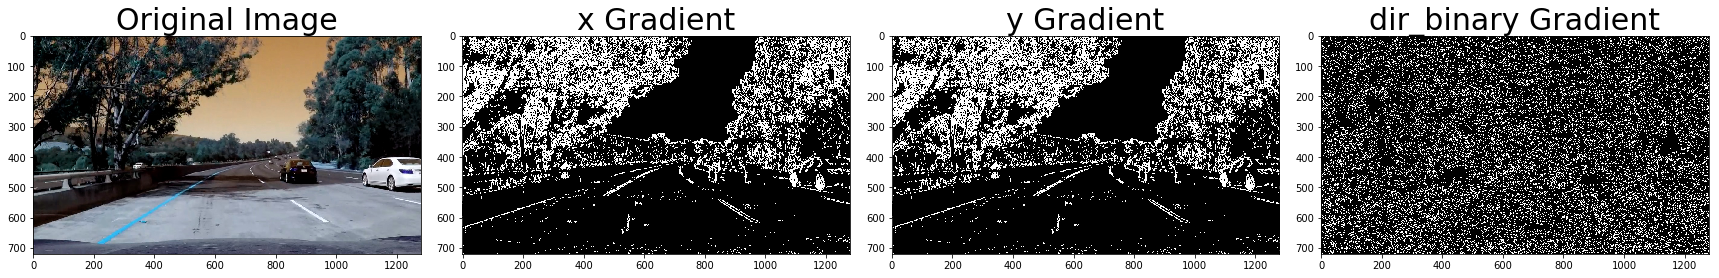

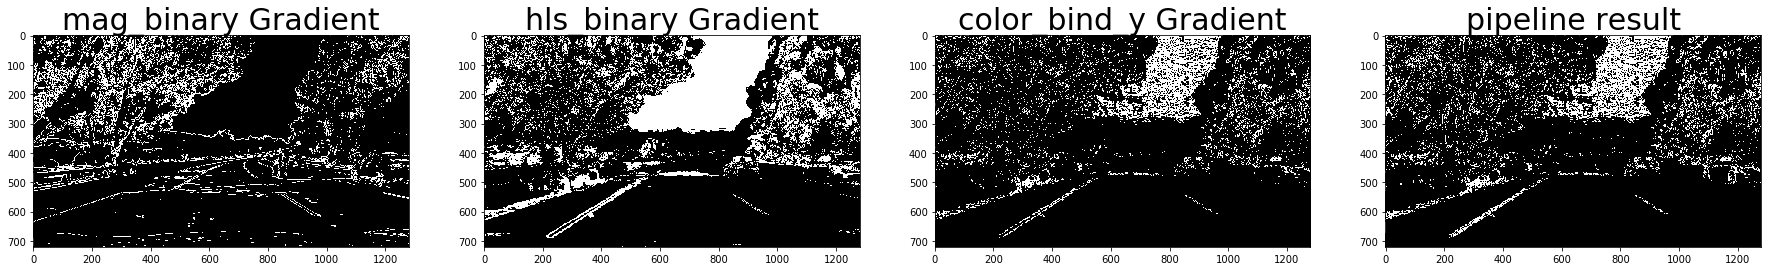

In [242]:
#image = cv2.imread('./test_images/test5.jpg')    
image = cv2.imread('./test_images/test5.jpg')    
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 250))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 250))
mag_binary = mag_threshold(image, sobel_kernel=ksize, thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize,  thresh=(1.0, 1.3))
hls_binary = hls_select(image, thresh=(75,200))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) & ((mag_binary == 1) )] = 1


             
color_binary = np.dstack(( np.zeros_like(dir_binary), dir_binary, hls_binary))

result = pipeline(image,s_thresh=s_thresh, sobel_x_thresh=sobel_x_thresh, \
                  mag_thresh=mag_thresh, dir_thresh=dir_thresh)
color_bind_y = np.zeros_like(result)
color_bind_y[((result == 1) & (hls_binary == 1))] = 1

f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('x Gradient', fontsize=30)
ax3.imshow(grady, cmap='gray')
ax3.set_title('y Gradient', fontsize=30)
ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('dir_binary Gradient', fontsize=30)

f2, (ax5,ax6,ax7,ax8) = plt.subplots(1, 4, figsize=(24, 9))
ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('mag_binary Gradient', fontsize=30)
ax6.imshow(hls_binary, cmap='gray')
ax6.set_title('hls_binary Gradient', fontsize=30)
ax7.imshow(color_bind_y, cmap='gray')
ax7.set_title('color_bind_y Gradient', fontsize=30)
ax8.imshow(result, cmap='gray')
ax8.set_title('pipeline result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Part 2: Find the Lane：

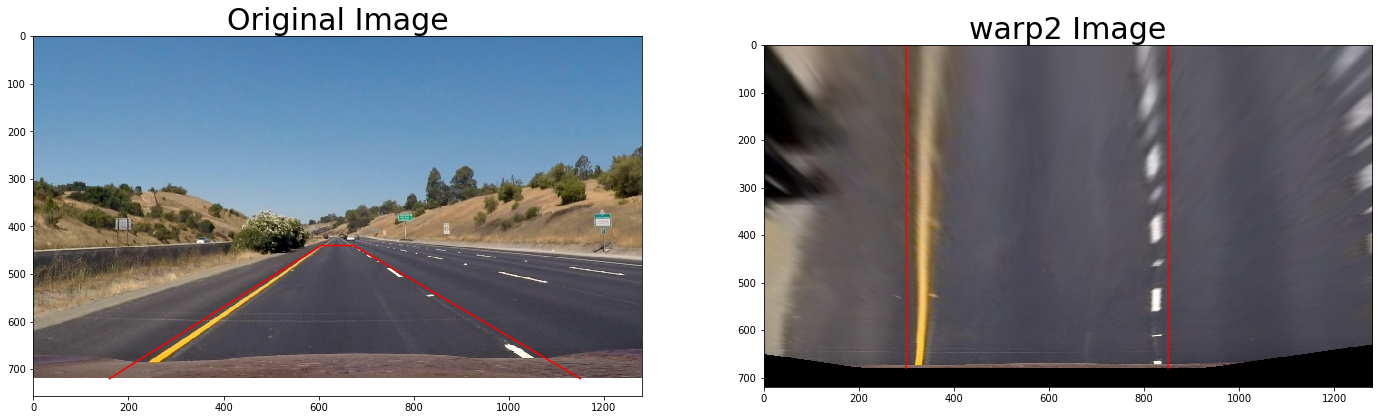

In [243]:
bottom_left = [160, 720]
top_left = [605, 440]
top_right = [673,440]
bottom_right = [1150,720]
def corners_unwarp(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(undist)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32([bottom_left,
                      top_left,
                      top_right,
                      bottom_right])
    dst = np.float32([[300,680],
                      [300,0],
                      [850,0],
                      [850,680]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_reverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, M_reverse
                      
image = mpimg.imread('./test_images/straight_lines1.jpg')
warp2, m_transor, m_reverse = corners_unwarp(image)


f2, (ax15,ax16) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax15.imshow(image)
ax15.plot([bottom_left[0],top_left[0],top_right[0],bottom_right[0]],
          [bottom_left[1],top_left[1],top_right[1],bottom_right[1]], color="red")
ax15.set_title('Original Image', fontsize=30)

ax16.imshow(warp2)
ax16.plot([300,300],[680,0], color="red")
ax16.plot([850,850],[0,680], color="red")
ax16.set_title('warp2 Image', fontsize=30)



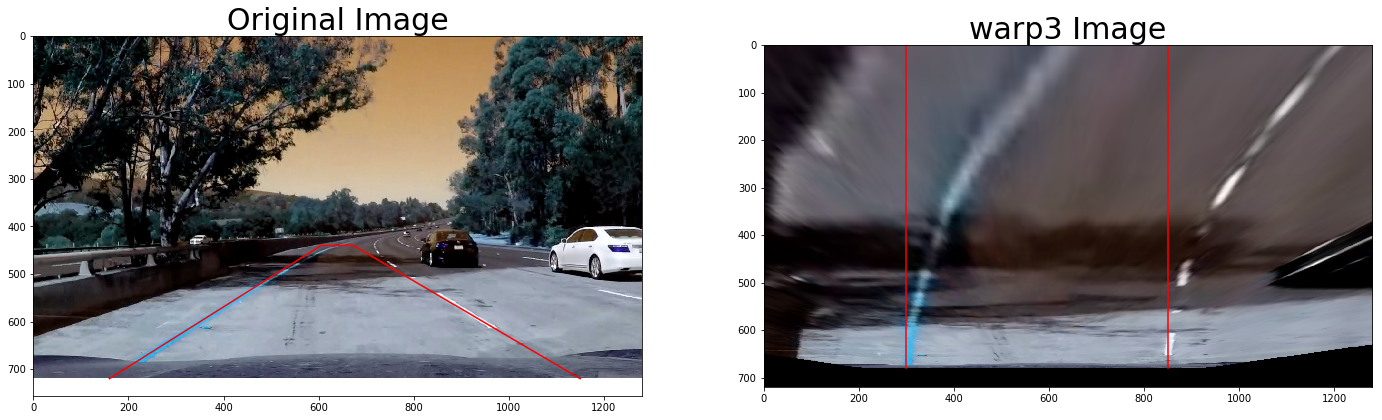

In [244]:
image = cv2.imread('./test_images/test5.jpg')
#image = cv2.imread('./test_images/test_new.png')
#image = mpimg.imread('./test_images/test_new.png')
#image = image[:,:,::-1]
# pylab_img[::-1,:,::-1] == cv_img
warp3, m_transor, m_reverse2 = corners_unwarp(image)


f2, (ax15,ax16) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax15.imshow(image)
ax15.plot([bottom_left[0],top_left[0],top_right[0],bottom_right[0]],
          [bottom_left[1],top_left[1],top_right[1],bottom_right[1]], color="red")
ax15.set_title('Original Image', fontsize=30)
ax16.imshow(warp3)

ax16.plot([300,300],[680,0], color="red")
ax16.plot([850,850],[0,680], color="red")
ax16.set_title('warp3 Image', fontsize=30)

(720, 1280, 3)


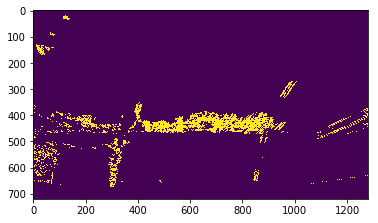

In [249]:
#result = np.float32(abs_sobel_thresh(warp3, orient='x', sobel_kernel=ksize, thresh=(10, 250)))
result =  np.float32(pipeline(warp3,s_thresh=s_thresh, sobel_x_thresh=sobel_x_thresh, \
                  mag_thresh=mag_thresh, dir_thresh=dir_thresh))
# color = cv2.cvtColor(gradx, cv2.COLOR_GRAY2RGB)
color = cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)  # Q1: why GRAY2RGB is black and white?
print(color.shape)
plt.imshow(result)


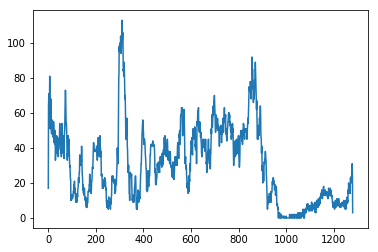

In [246]:
histogram = np.sum(result[result.shape[0]//2:, :], axis=0)
plt.plot(histogram)

### 找到Lane多项式系数

leftx_base 310 rightx_base 856


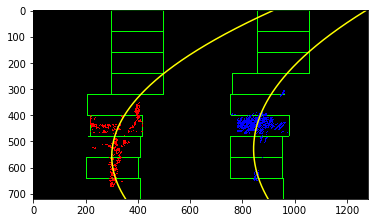

In [247]:
def find_lane_polyfit(img, visualize=False):

    binary_warped = img.copy()
    # 获取undistort图像
    warp, m_transor, m_reverse_ployfit = corners_unwarp(img)
    result =  np.float32(pipeline(warp,s_thresh=s_thresh, sobel_x_thresh=sobel_x_thresh, \
                  mag_thresh=mag_thresh, dir_thresh=dir_thresh))
    #color = cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    
    #img = np.zeros((512,512,3),np.uint8)
    histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((result, result, result))*255
    out_img = img = np.zeros_like(img, np.uint8)
#     plt.imshow(out_img)
#     return 'a'
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) # 1280/2 
    left_margin = 100
    leftx_base = np.argmax(histogram[left_margin:midpoint]) + left_margin
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = result.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    mean_pixes_right = 0
    mean_pixes_left = 0
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
#         if window == 3:
#             margin = 20
#         else:
#             margin = 100
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(20,20),(411,411),(55,255,155),5)
        # 画出多边形区域
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        # 点亮多边形区域内非0的点
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists

        # 多边形内亮点多于阈值后，取X平均值作为当前x的值。（移动方框）
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))            
#         if len(good_left_inds) > minpix:
#             # 如果框内的像素突然增多，则推断是有异常。 因此减小一般框大小，以降低影响。
#             if len(good_left_inds) > 2*mean_pixes_left and window != 0:
#                 win_xleft_low += margin/2
#                 win_xleft_high -= margin/2
#                 good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                
#             if nonzerox[good_left_inds] != []:
#                 leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#         if len(good_right_inds) > minpix:        
#             if len(good_right_inds) > 2*mean_pixes_right and window != 0:
#                 win_xright_low += margin/2
#                 win_xright_high -= margin/2 
#                 good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

#             if nonzerox[good_right_inds] != []:
#                 rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        # 每个多边形内亮点添加到数组
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        mean_pixes_left = (mean_pixes_left + len(good_left_inds)) / (window + 1)
        mean_pixes_right = (mean_pixes_right + len(good_right_inds)) / (window + 1)
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # 用多项式拟合所有的点。
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #visualize
    if visualize == True:
        print('leftx_base',leftx_base, 'rightx_base',rightx_base)
        ploty = np.linspace(0, color.shape[0]-1, color.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         plt.imshow(out_img)
        
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
        #plt.show()
        newwarp = cv2.warpPerspective(out_img, m_reverse_ployfit, (image.shape[1], image.shape[0])) 
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        test_i = out_img.copy()
        plt.imshow(out_img)        
    return left_fit, right_fit

left_fit, right_fit = find_lane_polyfit(image, visualize=True)

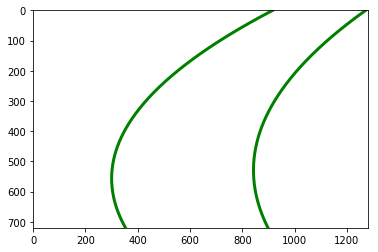

In [248]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # For each y position generate random x position within +/-50 pix
# # of the line base position in each case (x=200 for left, and x=900 for right)

# Fit a second order polynomial to pixel positions in each fake lane line
#left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# test_img = np.zeros_like(color)
# test_img_line = cv2.line(test_img, left_fitx, (255, 0, 0), 10)
# newwarp = cv2.warpPerspective(test_img_line, m_reverse, (test_img.shape[1], test_img.shape[0])) 

In [149]:
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad, left_fit, right_fit)

1539.88769068 12192.2422162 [  3.33553358e-04  -3.45121012e-01   3.95855880e+02] [ -4.11900138e-05   1.13354761e-01   7.94861567e+02]


In [150]:
def get_curverad(left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


#     leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#     rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    car_shift = (image.shape[1] / 2 - (left_fitx[-1] + right_fitx[-1]) / 2 ) * xm_per_pix
    
    return left_curverad, right_curverad, car_shift

left_curverad, right_curverad, car_shift = get_curverad(left_fit, right_fit)

print('left_curverad:', left_curverad, 'm', ' right_curverad:',right_curverad, 'm')
# Example values: 632.1 m    626.2 m

left_curverad: 492.570298909 m  right_curverad: 3987.33393402 m


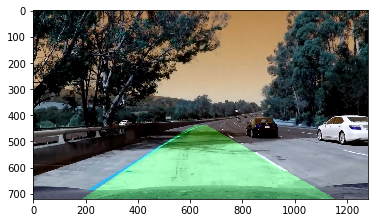

In [151]:
def DrawLane(color, left_fit, right_fit):
    # Create an image to draw the lines on
    # 两条线的坐标
    ploty = np.linspace(0, color.shape[0]-1, color.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    # 空白图案用于画线
    warp_zero = np.zeros_like(color).astype(np.uint8)
    color_warp = np.dstack((warp_zero[:,:,1], warp_zero[:,:,1], warp_zero[:,:,1]))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # 在空白图片上画出区域
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # 将空白图片透视还原回去
    newwarp = cv2.warpPerspective(color_warp, m_reverse, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    #result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #plt.imshow(color)
    return newwarp
    
result = DrawLane(color, left_fit, right_fit)
result = cv2.addWeighted(image, 1, result, 0.3, 0)
plt.imshow(result)

## Part3. For The Porject

In [152]:
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# calculate transor matix.   return the unwarp image.
def write_curverad_on_to_image(image, left_fit, right_fit):
    left_curverad, right_curverad, car_shift = get_curverad(left_fit, right_fit)
    text_line1 = 'Radius of Curvature = ' + str(int(left_curverad)) + '(m)'
    car_shift = float('%.2f' % car_shift)
    if car_shift < 0:
        shift_direction = 'right'
    else:
        shift_direction = 'left'
    text_test = str(left_fit) + '  ' + str(right_fit)
    text_line2 = 'Vehicle is ' + str(abs(car_shift)) + 'm ' + shift_direction + ' of center'
    cv2.putText(image, text_line1,(100,50), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),2)
    cv2.putText(image, text_line2,(100,120), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),2)
    #cv2.putText(image, text_test,(100,220), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),2)
class Process_image():    
    
    def __init__(self):
        self.fit_length = 60
        self.curverad_length = 60
        self.fit = {'left':[], 'right':[]}
        self.curverad = {'left':[], 'right':[]}
        
    def check_fit(self, fit_tuple):        
        
        for i in range(len(fit_tuple)):
            if i == 0:
                fit_type = 'left'
            elif i == 1:
                fit_type = 'right'
                
            for j in range(len(fit_tuple[i])):
                mean_a = 0
                for coefficients in self.fit[fit_type]:
                    mean += coefficients[j]
                mean = mean / len(self.fit[fit_type])

                # 如果异常，这个值不要，用上一次的系数代替, 正常则更新数组
                if abs(fit_tuple[i][j] - mean) > 1: 
                    fit_tuple[i][j] = self.fit[fit_type][0][j]
                else:
                    if len(self.fit[fit_type]) >= self.fit_length:
                        self.fit[fit_type].pop()
                    self.fit[fit_type].insert(0, fit_tuple[i][j])
                
                # Just deal a Now. ignore b and c
                break
                
        return fit_tuple
        
    def check_carvrad(self, fit_tuple):
        left_fit, right_fit = fit_tuple[0], fit_tuple[1]
        left_curverad, right_curverad, car_shift = get_curverad(left_fit, right_fit)
        
        for i in range(len(fit_tuple)):
            if i == 0:
                fit_type = 'left'
                curverad = left_curverad
            elif i == 1:
                fit_type = 'right'
                curverad = right_curverad
            
            # 只是比较curverad，仍然更新fit
            for j in range(len(fit_tuple)):
                if abs(curverad - np.mean(self.curverad[fit_type])) > 100:
                    fit_tuple[i][j] = self.fit[fit_type][0][j]
                else:
                    if len(self.fit[fit_type]) >= self.fit_length:
                        self.fit[fit_type].pop()
                    self.fit[fit_type].insert(0, fit_tuple[i][j])

        return fit_tuple
    
    def process_image(self, image):
        #image = image[::-1,:,::-1]
        # pipeline: 过滤颜色和梯度阈值。
        grad_color_threshold = pipeline(image,s_thresh=s_thresh, sobel_x_thresh=sobel_x_thresh, \
                  mag_thresh=mag_thresh, dir_thresh=dir_thresh)
        # 变成 X*Y*3的3D图片
        color = cv2.cvtColor(np.float32(grad_color_threshold),cv2.COLOR_GRAY2RGB) 
        # 用多项式匹配车道线
        left_fit, right_fit = find_lane_polyfit(color)
        #(left_fit, right_fit) = self.check_fit((left_fit,right_fit))
        (left_fit, right_fit) = self.check_carvrad((left_fit,right_fit))
        # 通过多项式画出车道区域（已透视变化）
        lane_area = DrawLane(color, left_fit, right_fit) 
        # 车道区域叠加到原图像
        result = cv2.addWeighted(image, 1, lane_area, 0.3, 0)
        # 在图片上写入当前弯道半径及偏离位置
        write_curverad_on_to_image(result, left_fit, right_fit)
        
        return result
    
    
obj = Process_image()
image = plt.imread('./test_images/test2.jpg')  
result = obj.process_image(image)
plt.imshow(result)

obj = Process_image()
lane_basic_output = './output_images/drawLane_basic.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip_basic = VideoFileClip("./project_video.mp4").subclip(0,48)

white_clip = clip_basic.fl_image(obj.process_image) 
%time white_clip.write_videofile(lane_basic_output, audio=False)

TypeError: expected non-empty vector for x

## challenge

In [ ]:


lane_basic_output = './output_images/drawLane_challenge.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip_basic = VideoFileClip("challenge_video.mp4")

white_clip = clip_basic.fl_image(process_image) 
%time white_clip.write_videofile(lane_basic_output, audio=False)

In [ ]:


lane_basic_output = './output_images/drawLane__harder_challenge.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip_basic = VideoFileClip("harder_challenge_video.mp4")

white_clip = clip_basic.fl_image(process_image) 
%time white_clip.write_videofile(lane_basic_output, audio=False)